# Segmentation
Segmentation describes the process of finding cells in an image. This can be done either on the nucleus or on whole cell level. Spatialproteomics provides wrappers for StarDist, mesmer and cellpose.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# loading the input data
ds = xr.open_zarr("../../data/segmentation_example.zarr").pp[1000:1300, 1000:1300].pp.drop_layers(keep="_image")

In [4]:
# checking what the object initially looks like
ds

<xarray.Dataset>
Dimensions:   (channels: 4, y: 301, x: 301)
Coordinates:
  * channels  (channels) <U11 'DAPI' 'Na/K ATPase' 'CD68' 'CD11c'
  * x         (x) int64 1000 1001 1002 1003 1004 ... 1296 1297 1298 1299 1300
  * y         (y) int64 1000 1001 1002 1003 1004 ... 1296 1297 1298 1299 1300
Data variables:
    _image    (channels, y, x) uint8 dask.array<chunksize=(4, 301, 301), meta=np.ndarray>

## Whole-Cell Segmentation with Cellpose

Cellpose can either perform segmentation on nuclei only or on whole cells, using a nuclear and a membrane marker. In this dataset, we have DAPI as a nuclear marker and Na/K ATPase as a membrane marker. After selecting only the relevant markers, we need to tell cellpose at what position each marker is. You can refer to the [cellpose documentation](https://cellpose.readthedocs.io/en/latest/settings.html) for more details.

In [5]:
# running the segmentation on the selected markers
ds_cellpose = ds.tl.cellpose(channel=["Na/K ATPase", "DAPI"], channel_settings=[1, 2])
ds_cellpose

Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>> cyto3 << model set to be used
>>>> loading model /home/meyerben/.cellpose/models/cyto3
/home/meyerben/meyerben/.conda/envs/tmp_env_2/lib/python3.10/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

<xarray.Dataset>
Dimensions:        (channels: 4, y: 301, x: 301, cells: 330, features: 2)
Coordinates:
  * channels       (channels) <U11 'DAPI' 'Na/K ATPase' 'CD68' 'CD11c'
  * x              (x) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y              (y) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * cells          (cells) int64 1 2 3 4 5 6 7 8 ... 324 325 326 327 328 329 330
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 dask.array<chunksize=(4, 301, 301), meta=np.ndarray>
    _segmentation  (y, x) uint16 0 1 1 1 1 1 1 1 ... 324 324 324 324 324 324 0
    _obs           (cells, features) float64 1.005e+03 1.011e+03 ... 1.003e+03

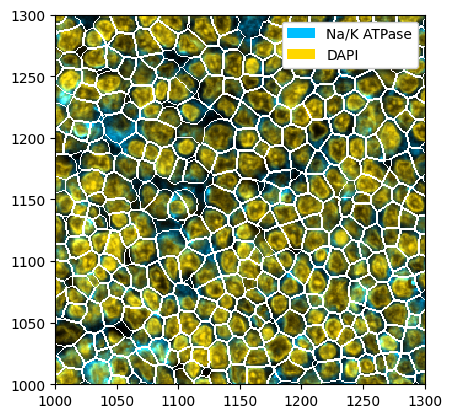

In [6]:
# for plotting, we subselect the two markers from before, but you could also show the other markers
_ = ds_cellpose.pp[["Na/K ATPase", "DAPI"]].pl.colorize(["deepskyblue", "gold"]).pl.show(render_segmentation=True)

## Whole-Cell Segmentation with Mesmer

You can also do the same thing with mesmer. Note however that mesmer expects the channels to be in the order `[nuclear, membrane]`.

2025-04-26 10:34:56.665731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /g/huber/users/meyerben/.conda/envs/tmp_env_2/lib/python3.10/site-packages/cv2/../../lib64:
2025-04-26 10:34:56.665762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Checking for cached data
Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
Extracting /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz
Successfully extracted /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz into /home/meyerben/.deepcell/models
2025-04-26 10:35:54.735799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

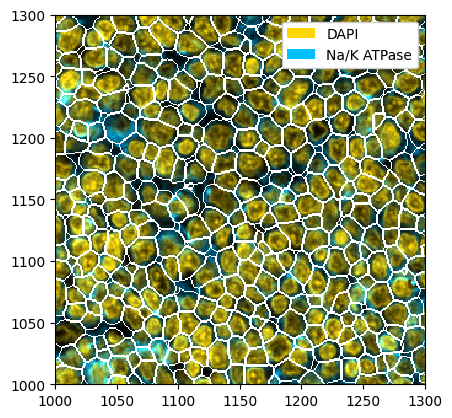

In [7]:
# running mesmer
ds_mesmer = ds.tl.mesmer(channel=["DAPI", "Na/K ATPase"])
# plotting the result
_ = ds_mesmer.pp[["DAPI", "Na/K ATPase"]].pl.colorize(["gold", "deepskyblue"]).pl.show(render_segmentation=True)

## Nuclear Segmentation with StarDist

Sometimes, you may not have a membrane stain available. In that case, you can perform nuclear segmentation. This is possible with cellpose (simply call `tl.cellpose(channel='DAPI')`) and StarDist.
The following shows and example of how StarDist performs on such a task.

In [8]:
# running stardist
ds_stardist = ds.tl.stardist(channel="DAPI")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 144/144 [00:08<00:00, 17.58it/s]


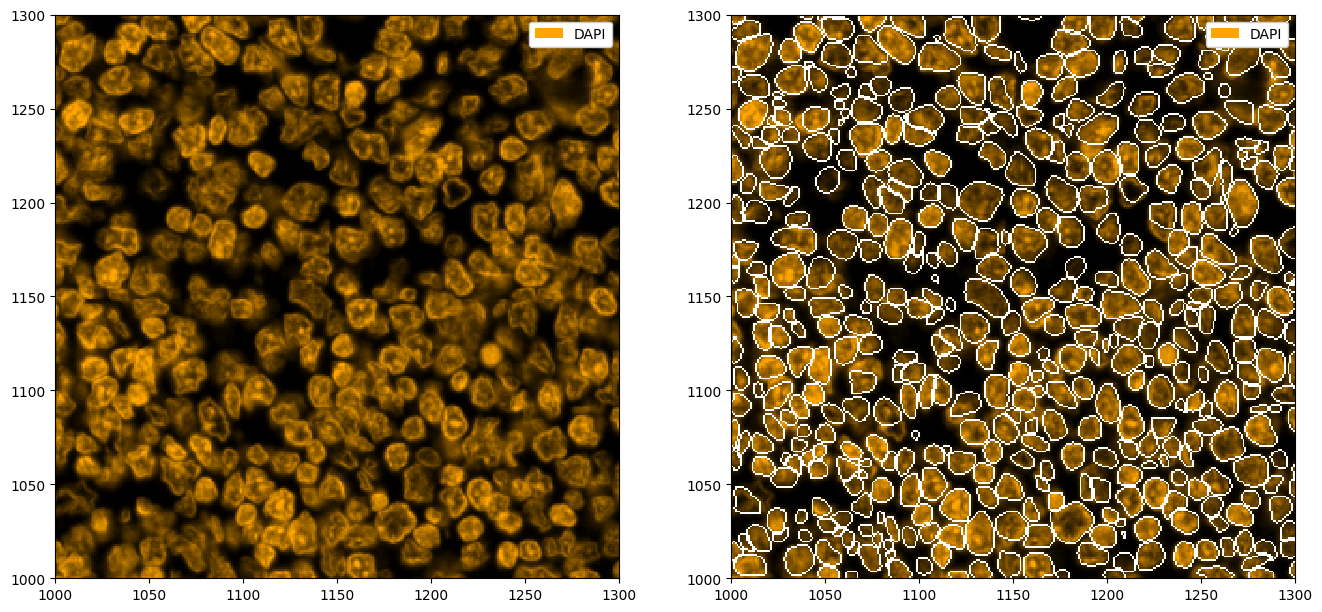

In [9]:
# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(ax=ax[0])
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1])

You might have noticed that StarDist tends to segment a lot of small cells. Let's look at the distribution of cell sizes, and then remove all nuclei under a certain size.

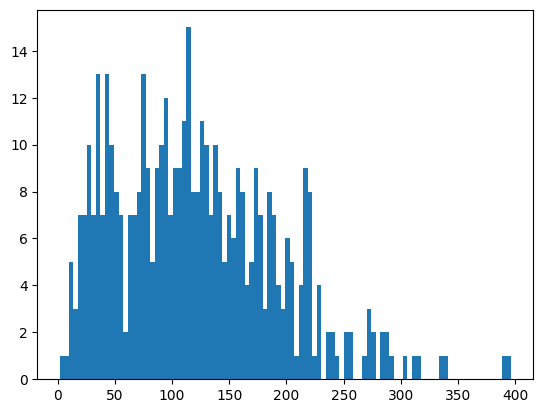

In [10]:
# getting a histogram of the areas
_ = plt.hist(ds_stardist.pp.add_observations("area").pp.get_layer_as_df()["area"], bins=100)

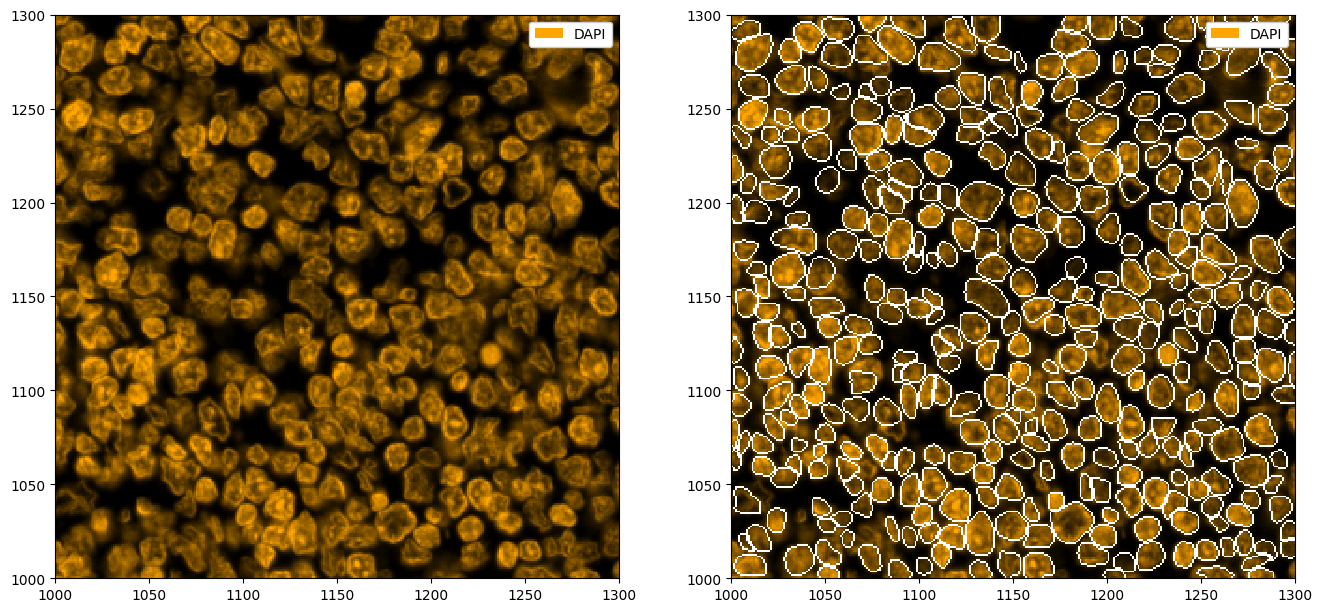

In [11]:
# removing cells which have an area below 50 pixels
ds_stardist = ds_stardist.pp.add_observations("area").pp.filter_by_obs("area", lambda x: x > 50)

# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(ax=ax[0])
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1])

To try to capture full cells, we can now grow the segmentation masks, e. g. by two pixels into each direction. If two masks collide, the masks will stop growing into that direction.

In [12]:
ds_stardist_grown = ds_stardist.pp.grow_cells(2)

Mask growing requires recalculation of the observations. All features other than the centroids will be removed and should be recalculated with pp.add_observations().


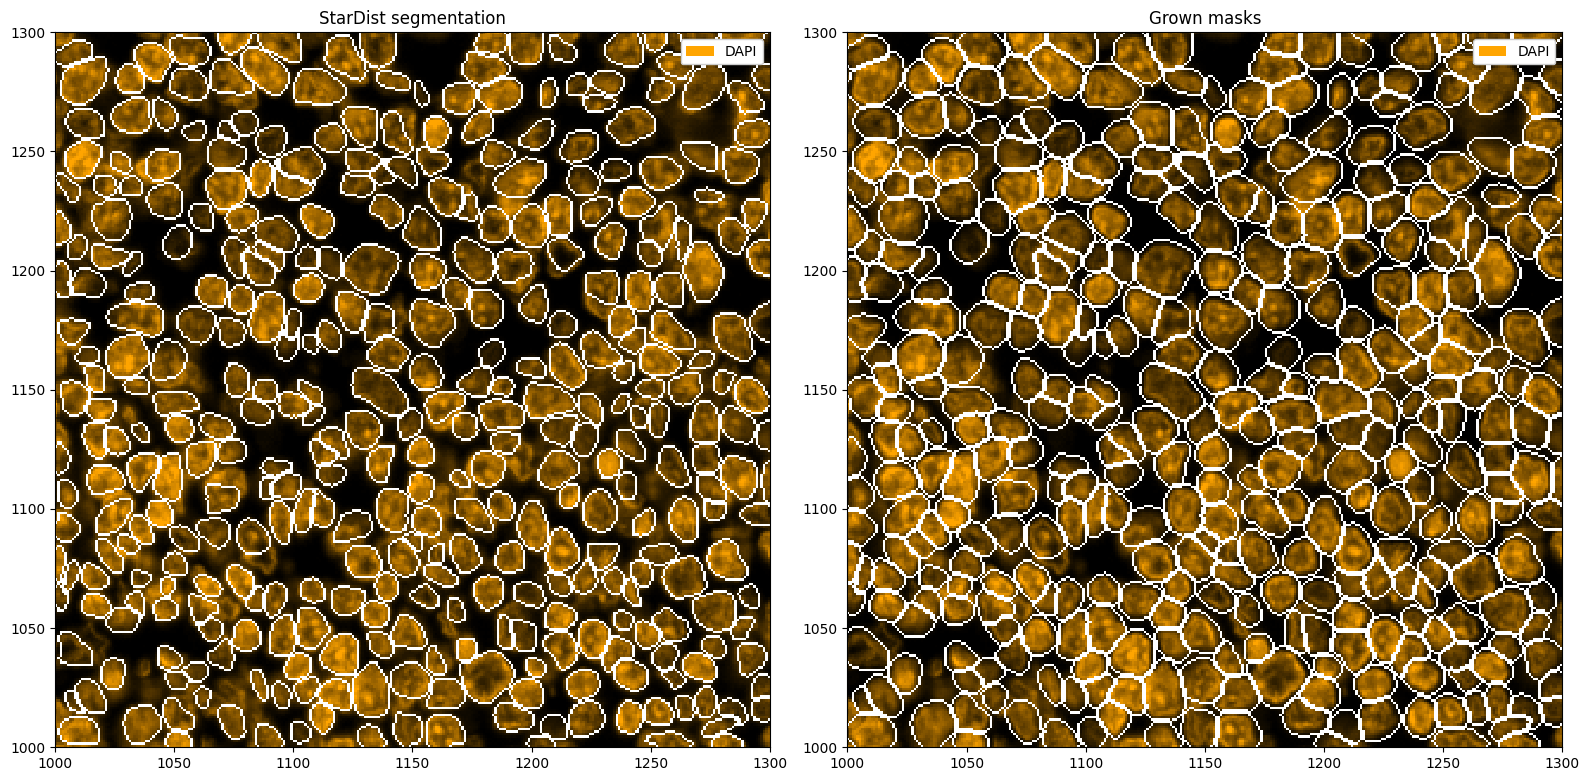

In [13]:
# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[0])
_ = ds_stardist_grown.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1])
ax[0].set_title("StarDist segmentation")
ax[1].set_title("Grown masks")
plt.tight_layout()

## Segmenting Multiple Channels with Cellpose

Next to predicting nuclei or whole cells using a universal membrane marker, you can also use cellpose to try to predict other cell types. In the following, we will see how we can use cellpose to segment three different channels independently and then merge the segmentation masks into one mask. There are some hyperparameters in cellpose which can help the prediction.

In [14]:
# segmenting on DAPI, CD11c (dendritic cells) and CD68 (macrophages)
# note that when merging the masks later, the order matters (channels take precedence by position in the subsetting)
# so you should have your largest cells first, and then go down by expected size
ds_cellpose = ds.pp[["CD11c", "CD68", "DAPI"]].tl.cellpose(key_added="_cellpose_segmentation")

Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>> cyto3 << model set to be used
>>>> loading model /home/meyerben/.cellpose/models/cyto3
resnet_torch.py (280): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Git

In [15]:
ds_cellpose

<xarray.Dataset>
Dimensions:                 (channels: 3, y: 301, x: 301)
Coordinates:
  * channels                (channels) <U11 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 1000 1001 1002 1003 ... 1298 1299 1300
Data variables:
    _image                  (channels, y, x) uint8 dask.array<chunksize=(3, 301, 301), meta=np.ndarray>
    _cellpose_segmentation  (channels, y, x) uint16 0 0 0 0 0 0 ... 320 0 0 0 0

In [16]:
# merging the segmentation masks into a single segmentation
# the threshold value tells you how much of a mask need to overlap for the less important one to be removed
ds_cellpose_merged = ds_cellpose.pp.merge_segmentation(
    "_cellpose_segmentation", labels=["Dendritic Cell", "Macrophage", "Lymphocyte"], threshold=0.8
)

In [17]:
ds_cellpose_merged

<xarray.Dataset>
Dimensions:                 (channels: 3, y: 301, x: 301)
Coordinates:
  * channels                (channels) <U11 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 1000 1001 1002 1003 ... 1298 1299 1300
Data variables:
    _image                  (channels, y, x) uint8 dask.array<chunksize=(3, 301, 301), meta=np.ndarray>
    _cellpose_segmentation  (channels, y, x) uint16 0 0 0 0 0 0 ... 320 0 0 0 0
    _merged_segmentation    (y, x) uint16 0 0 0 0 0 25 25 25 ... 0 0 0 0 0 0 0 0

In [18]:
# adding the merged segmentation as the main segmentation in the object
# this is done so that we can visualize the result with pl.show(render_segmentation=True), without needing to specify which segmentation we want to show
ds_cellpose_merged = ds_cellpose_merged.pp.add_segmentation("_merged_segmentation")

In [19]:
ds_cellpose_merged

<xarray.Dataset>
Dimensions:                 (labels: 3, la_props: 2, channels: 3, x: 301,
                             y: 301, cells: 296, features: 3)
Coordinates:
  * labels                  (labels) int64 1 2 3
  * la_props                (la_props) <U6 '_color' '_name'
  * channels                (channels) <U11 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * cells                   (cells) int64 1 2 3 4 5 6 ... 292 293 294 295 296
  * features                (features) <U10 '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _la_properties          (labels, la_props) object '#C8A1A1' ... 'Macrophage'
    _image                  (channels, y, x) uint8 dask.array<chunksize=(3, 301, 301), meta=np.ndarray>
    _cellpose_segmentation  (channels, y, x) uint16 0 0 0 0 0 0 ... 320 0 0 0 0
    _merged_segmentation    (y, x) uint16 0 0 0 0 0 25 25 25 ... 0 0 0 0 0 0 0 0
    _obs                    (cells, features) float64 1.0 1.04e+03 ... 1.003e+03
    _segmentation           (y, x) uint16 0 0 0 0 0 25 25 25 ... 0 0 0 0 0 0 0 0

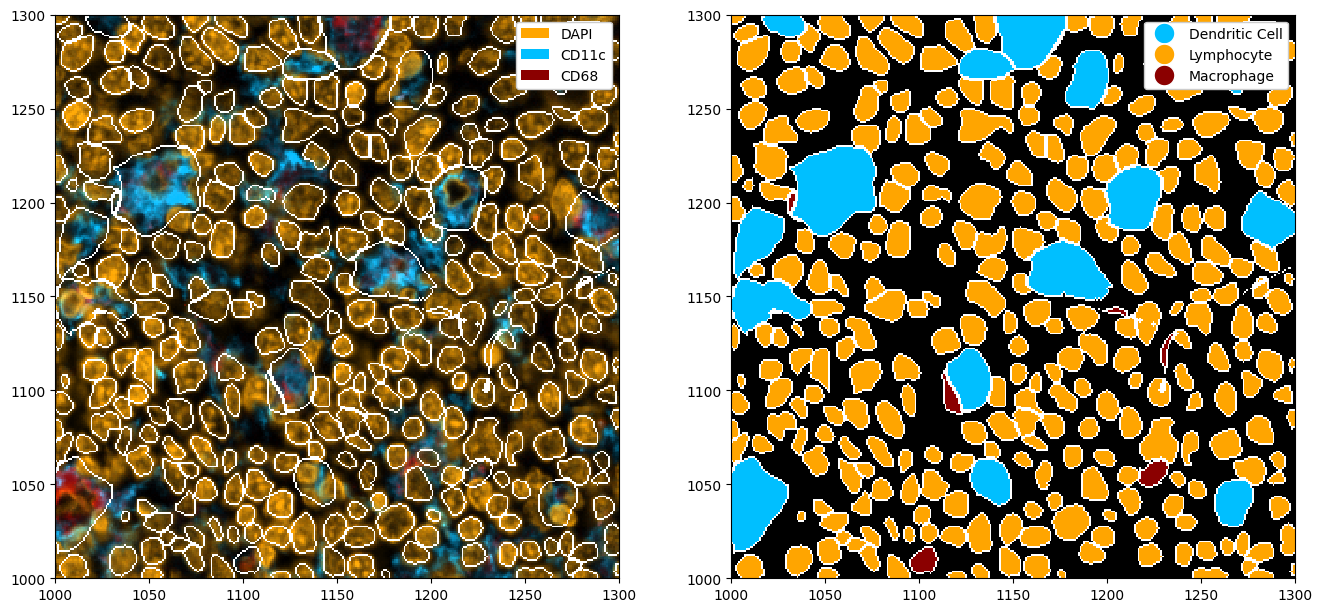

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# adding colors to match the channel colors
colors = ["orange", "deepskyblue", "darkred"]
ds_cellpose_merged = ds_cellpose_merged.la.set_label_colors(["Lymphocyte", "Dendritic Cell", "Macrophage"], colors)

# merged masks
_ = (
    ds_cellpose_merged.pp[["DAPI", "CD11c", "CD68"]]
    .pl.colorize(colors=colors)
    .pl.show(render_segmentation=True, ax=ax[0])
)
_ = ds_cellpose_merged.pl.show(
    render_image=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[1]
)

Note that this method is far from perfect, and does not always pick up on all masks. In this case, you might want to look into fine-tuning cellpose to your celltype of interest. You can also tweak the cellpose parameters to try to improve the segmentation.

## Merging Segmentation Masks from Different Layers

In the previous section, we looked at how to merge masks from a single layer. But what do we do if we have multiple segmentations in different layers?

Let us consider an example. Mesmer always requires two channels to segment an image (a nuclear and a membrane stain). We can run mesmer on our membrane stain, and then run cellpose on the macrophages and dendritic cells. However, now our segmentation masks are stored in different layers. The good thing is, we can combine them just as easily by using `pp.merge_segmentation()`.

In [21]:
# running mesmer and cellpose to obtain a bunch of different segmentation masks
# these are stored in the layers dapi_seg, macro_seg, and dendritic_seg
ds_mesmer = (
    ds.tl.mesmer(channel=["DAPI", "Na/K ATPase"], key_added="dapi_seg")
    .tl.cellpose(channel="CD68", key_added="macro_seg")
    .tl.cellpose(channel="CD11c", key_added="dendritic_seg")
)
ds_mesmer

Checking for cached data
Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
Extracting /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz
Successfully extracted /home/meyerben/.deepcell/models/MultiplexSegmentation-9.tar.gz into /home/meyerben/.deepcell/models
No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Converting image dtype to float
Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>> cyto3 << model set to be used
>>>> loading model /home/meyerben/.cellpose/models/cyto3
resnet_torch.py (280): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main

<xarray.Dataset>
Dimensions:        (channels: 4, y: 301, x: 301)
Coordinates:
  * channels       (channels) <U11 'DAPI' 'Na/K ATPase' 'CD68' 'CD11c'
  * x              (x) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y              (y) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
Data variables:
    _image         (channels, y, x) uint8 dask.array<chunksize=(4, 301, 301), meta=np.ndarray>
    dapi_seg       (y, x) int64 11 11 11 11 11 11 11 ... 348 348 348 348 348 348
    macro_seg      (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    dendritic_seg  (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

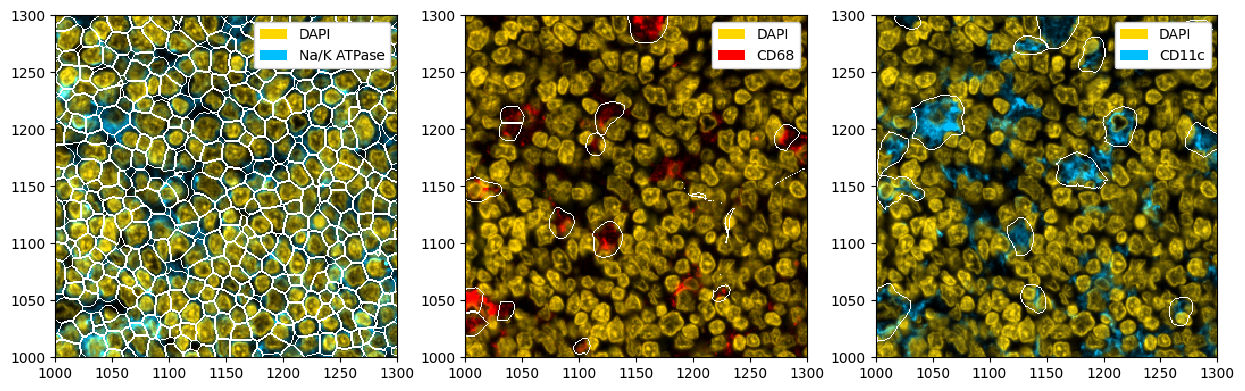

In [22]:
# plotting the individual masks
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
_ = (
    ds_mesmer.pp[["DAPI", "Na/K ATPase"]]
    .pl.colorize(["gold", "deepskyblue"])
    .pl.show(render_segmentation=True, segmentation_kwargs={"layer_key": "dapi_seg"}, ax=ax[0])
)

_ = (
    ds_mesmer.pp[["DAPI", "CD68"]]
    .pl.colorize(["gold", "red"])
    .pl.show(render_segmentation=True, segmentation_kwargs={"layer_key": "macro_seg"}, ax=ax[1])
)

_ = (
    ds_mesmer.pp[["DAPI", "CD11c"]]
    .pl.colorize(["gold", "deepskyblue"])
    .pl.show(render_segmentation=True, segmentation_kwargs={"layer_key": "dendritic_seg"}, ax=ax[2])
)

In [23]:
# merging the segmentation masks and making the merged segmentation the default one
ds_mesmer = ds_mesmer.pp.merge_segmentation(
    layer_key=["dendritic_seg", "macro_seg", "dapi_seg"],
    labels=["Dendritic Cell", "Macrophage", "Lymphocyte"],
    threshold=0.8,
).pp.add_segmentation("_merged_segmentation")

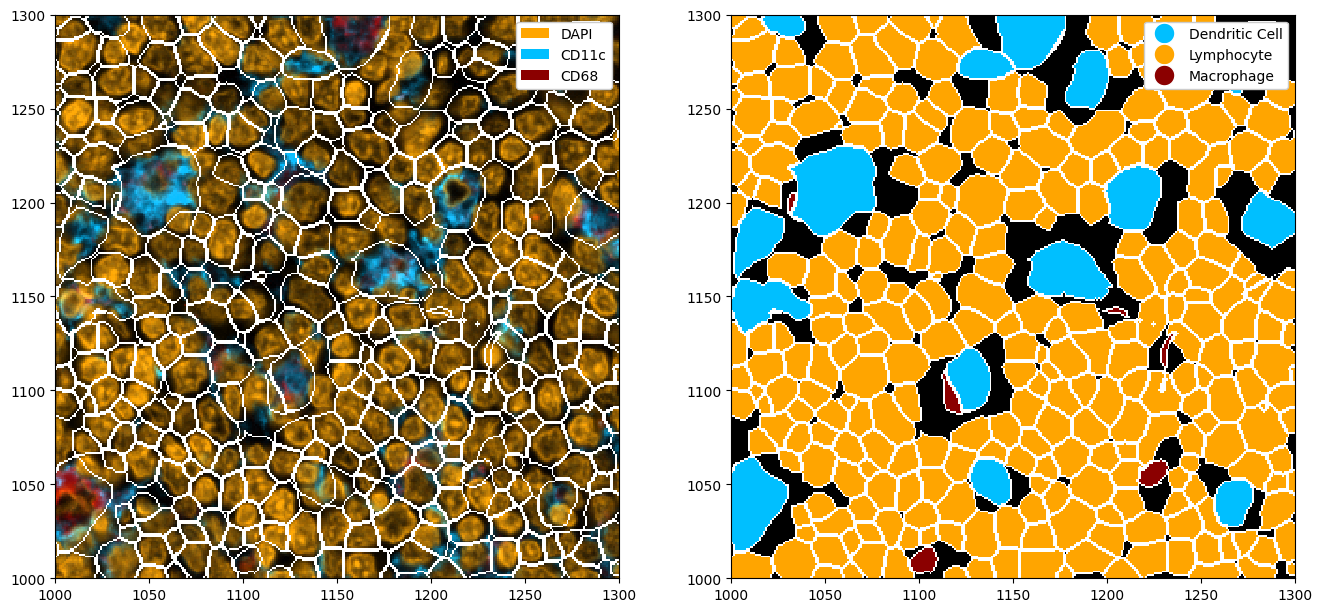

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# adding colors to match the channel colors
colors = ["orange", "deepskyblue", "darkred"]
ds_mesmer = ds_mesmer.la.set_label_colors(["Lymphocyte", "Dendritic Cell", "Macrophage"], colors)

# merged masks
_ = ds_mesmer.pp[["DAPI", "CD11c", "CD68"]].pl.colorize(colors=colors).pl.show(render_segmentation=True, ax=ax[0])
_ = ds_mesmer.pl.show(render_image=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[1])